# Create complete network
- get all layers created so far (grid, roads for cars and bikes, public transport layer(s))
- put them all in one network

In [1]:
import networkx as nx
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import shapely

crs_fr = 4326 #2154 ?

## Gather all layers 

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_15249/4258537137.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_centroids.centroid.plot(ax=ax, markersize=1, facecolor = 'green')


<Axes: >

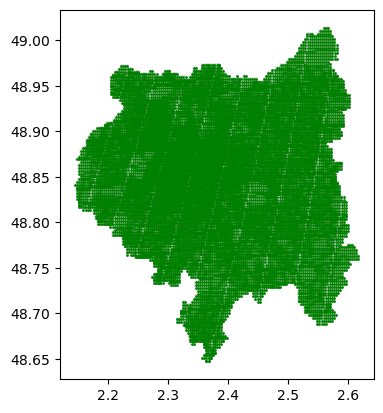

In [2]:
# Get grid
grid_centroids = pd.read_csv('data/processed/GPM_grid.csv')

# turn into geodataframe
for c in ['geometry', 'centroid']:
    grid_centroids[c] = grid_centroids[c].apply(shapely.wkt.loads)
grid_centroids = gpd.GeoDataFrame(grid_centroids, crs = crs_fr, geometry= 'geometry' )

# plot
ax = plt.axes()
grid_centroids.plot(ax=ax, facecolor="none", edgecolor='grey', linewidth = 0.1)
grid_centroids.centroid.plot(ax=ax, markersize=1, facecolor = 'green')


<Axes: >

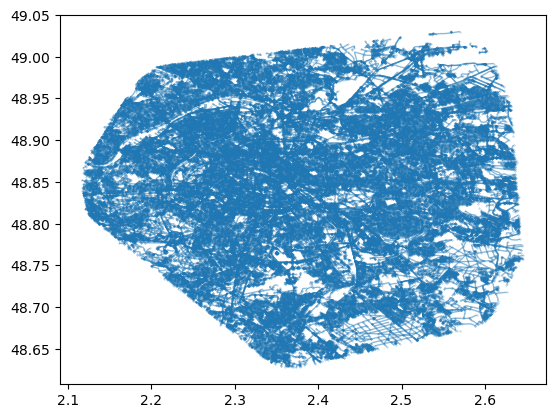

In [7]:
# Get roads (car and bike)
nodes_carbike = pd.read_csv("./data/processed/carbike_nodes_done.csv")
edges_carbike = pd.read_csv("./data/processed/carbike_edges_done.csv")

# Turn into GeoDataframe
edges_carbike["geometry"] = edges_carbike.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
edges_carbike = gpd.GeoDataFrame(edges_carbike, geometry = "geometry") 
nodes_carbike["geometry"] = nodes_carbike.apply(lambda x: shapely.wkt.loads(x.geometry), axis = 1)
nodes_carbike = gpd.GeoDataFrame(nodes_carbike, geometry = "geometry")

# Plot
ax = plt.axes()
edges_carbike.plot(ax=ax, linewidth = 1, alpha = 0.5)
nodes_carbike.plot(ax=ax, markersize = 0.1, alpha = 0.5)

## Combine all layers

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_15249/2480440147.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_centroids.centroid.plot(ax=ax, markersize=0.1, facecolor = 'green')


<Axes: >

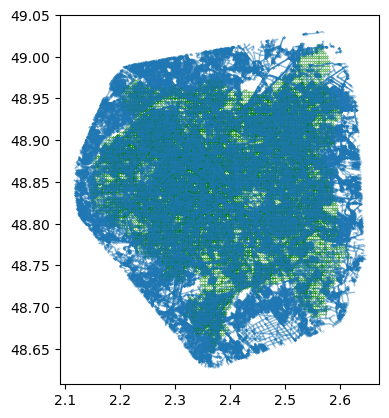

In [8]:
# Plot
ax = plt.axes()
edges_carbike.plot(ax=ax, linewidth = 1, alpha = 0.5)
nodes_carbike.plot(ax=ax, markersize = 0.1, alpha = 0.5)
grid_centroids.centroid.plot(ax=ax, markersize=0.1, facecolor = 'green')

In [9]:
# Ensure that grid points coincide with network nodes

In [10]:
# Create NetworkX Graph with all layers